In [45]:
import sys
sys.path.append('../astro_tools')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from tqdm import tqdm
from astropy.wcs import wcs
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import ImageGrid
from reproject import reproject_interp
from astropy import units as u
from matplotlib.lines import Line2D
# from astropy.visualization.wcsaxes import add_beam, add_scalebar
from spectral_cube import SpectralCube
import cmasher as cmr

# set up the plot
plt.rcParams['text.usetex'] = False
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.5
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams["font.family"] = "courier new"
plt.rcParams["font.style"] = "normal"
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.weight"] = 'bold'

import warnings
warnings.filterwarnings('ignore')

Set variables.

In [2]:
num_obs = 150
free_params1 = 6
free_params2 = 12
free_params3 = 18
savepath1 = '../../ngc253/June21/fits1_total/'
savepath2 = '../../ngc253/June21/fits2_total/'
savepath3 = '../../ngc253/June21/fits3_total/'
infile1 = '%sfits1_reordered.txt' % savepath1
infile2 = '%sfits2_reordered.txt' % savepath2
infile3 = '%sfits3_reordered.txt' % savepath3
ERRinfile1 = '%sfits1_err_reordered.txt' % savepath1
ERRinfile2 = '%sfits2_err_reordered.txt' % savepath2
ERRinfile3 = '%sfits3_err_reordered.txt' % savepath3

fits1 = pd.read_csv(infile1)
fits2 = pd.read_csv(infile2)
fits3 = pd.read_csv(infile3)
ERRfits1 = pd.read_csv(ERRinfile1)
ERRfits2 = pd.read_csv(ERRinfile2)
ERRfits3 = pd.read_csv(ERRinfile3)

# get info of original data
og = '../../ngc253/data/ADP.2018-11-22T21_29_46.157.fits'
hdu = fits.open(og)[1]
og_data = hdu.data
y, x = og_data[1].shape
w = wcs.WCS(hdu.header, naxis=2).celestial

# open the BIC_PHYS test fits file
which_model_infile = '../../ngc253/June21/BIC_PHYS_50.fits'
hdu_BIC = fits.open(which_model_infile)
which_model = hdu_BIC[0].data

# open the disk velocity model
disk_map_infile = '../../ngc253/data/ngc253_se_halpha_vel_model_smooth_FINAL.fits'
hdu_Ha = fits.open(disk_map_infile)
disk_map = hdu_Ha[0].data

Get everything into numpy arrays! Working with NIIb.

In [3]:
BIC_map1 = np.empty((y,x))
BIC_map2 = np.empty((y,x))
BIC_map3 = np.empty((y,x))
redchisq_map1 = np.empty((y,x))
redchisq_map2 = np.empty((y,x))
redchisq_map3 = np.empty((y,x))
amp_map1 = np.empty((y,x))
amp_map2_b = np.empty((y,x))
amp_map2_r = np.empty((y,x))
amp_map3_b = np.empty((y,x))
amp_map3_0 = np.empty((y,x))
amp_map3_r = np.empty((y,x))
vel_map1 = np.empty((y,x))
vel_map2_b = np.empty((y,x))
vel_map2_r = np.empty((y,x))
vel_map3_b = np.empty((y,x))
vel_map3_0 = np.empty((y,x))
vel_map3_r = np.empty((y,x))
fwhm_map1 = np.empty((y,x))
fwhm_map2_b = np.empty((y,x))
fwhm_map2_r = np.empty((y,x))
fwhm_map3_b = np.empty((y,x))
fwhm_map3_0 = np.empty((y,x))
fwhm_map3_r = np.empty((y,x))

# make maps of the BICs, velocities, and FWHMs
for index, row in fits1.iterrows():
    redchisq_map1[int(row['Y']), int(row['X'])] = row['RedChiSq']
    BIC_map1[int(row['Y']), int(row['X'])] = row['BIC']
    amp_map1[int(row['Y']), int(row['X'])] = row['Amp3'] #row['Vel2']
    vel_map1[int(row['Y']), int(row['X'])] = row['Vel3'] #row['Vel2']
    fwhm_map1[int(row['Y']), int(row['X'])] = row['SigVel3'] 
for index, row in fits2.iterrows():
    redchisq_map2[int(row['Y']), int(row['X'])] = row['RedChiSq']
    BIC_map2[int(row['Y']), int(row['X'])] = row['BIC']
    amp_map2_b[int(row['Y']), int(row['X'])] = row['Amp5'] #row['Vel3']
    amp_map2_r[int(row['Y']), int(row['X'])] = row['Amp6'] #row['Vel4']
    vel_map2_b[int(row['Y']), int(row['X'])] = row['Vel5'] #row['Vel3']
    vel_map2_r[int(row['Y']), int(row['X'])] = row['Vel6'] #row['Vel4']
    fwhm_map2_b[int(row['Y']), int(row['X'])] = row['SigVel5']#row['SigVel3']
    fwhm_map2_r[int(row['Y']), int(row['X'])] = row['SigVel6']#row['SigVel4']
for index, row in fits3.iterrows():
    redchisq_map3[int(row['Y']), int(row['X'])] = row['RedChiSq']
    BIC_map3[int(row['Y']), int(row['X'])] = row['BIC']
    amp_map3_b[int(row['Y']), int(row['X'])] = row['Amp7'] #row['Vel4']
    amp_map3_0[int(row['Y']), int(row['X'])] = row['Amp8']#row['Vel5']
    amp_map3_r[int(row['Y']), int(row['X'])] = row['Amp9']#row['Vel6']
    vel_map3_b[int(row['Y']), int(row['X'])] = row['Vel7'] #row['Vel4']
    vel_map3_0[int(row['Y']), int(row['X'])] = row['Vel8']#row['Vel5']
    vel_map3_r[int(row['Y']), int(row['X'])] = row['Vel9']#row['Vel6']
    fwhm_map3_b[int(row['Y']), int(row['X'])] = row['SigVel7']#row['SigVel4']
    fwhm_map3_0[int(row['Y']), int(row['X'])] = row['SigVel8']#row['SigVel5']
    fwhm_map3_r[int(row['Y']), int(row['X'])] = row['SigVel9']#row['SigVel6']

# blank out edges
BIC_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
BIC_map2[np.isnan(og_data[1])] = np.nan # [0] has some nans within
BIC_map3[np.isnan(og_data[1])] = np.nan # [0] has some nans within
redchisq_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
redchisq_map2[np.isnan(og_data[1])] = np.nan # [0] has some nans within
redchisq_map3[np.isnan(og_data[1])] = np.nan # [0] has some nans within
amp_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
amp_map2_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
amp_map2_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
amp_map3_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
amp_map3_0[np.isnan(og_data[1])] = np.nan # [0] has some nans within
amp_map3_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
vel_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
vel_map2_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
vel_map2_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
vel_map3_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
vel_map3_0[np.isnan(og_data[1])] = np.nan # [0] has some nans within
vel_map3_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
fwhm_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
fwhm_map2_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
fwhm_map2_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
fwhm_map3_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
fwhm_map3_0[np.isnan(og_data[1])] = np.nan # [0] has some nans within
fwhm_map3_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within



In [4]:
ERRamp_map1 = np.empty((y,x))
ERRamp_map2_b = np.empty((y,x))
ERRamp_map2_r = np.empty((y,x))
ERRamp_map3_b = np.empty((y,x))
ERRamp_map3_0 = np.empty((y,x))
ERRamp_map3_r = np.empty((y,x))

ERRvel_map1 = np.empty((y,x))
ERRvel_map2_b = np.empty((y,x))
ERRvel_map2_r = np.empty((y,x))
ERRvel_map3_b = np.empty((y,x))
ERRvel_map3_0 = np.empty((y,x))
ERRvel_map3_r = np.empty((y,x))

for index, row in ERRfits1.iterrows():
    ERRamp_map1[int(row['Y']), int(row['X'])] = row['rms'] * row['Amp3'] # estimated error
    ERRvel_map1[int(row['Y']), int(row['X'])] = row['rms'] * row['Vel3']  # estimated error
for index, row in ERRfits2.iterrows():
    ERRamp_map2_b[int(row['Y']), int(row['X'])] = row['rms'] * row['Amp5']
    ERRamp_map2_r[int(row['Y']), int(row['X'])] = row['rms'] * row['Amp6']
    ERRvel_map2_b[int(row['Y']), int(row['X'])] = row['rms'] * row['Vel5']
    ERRvel_map2_r[int(row['Y']), int(row['X'])] = row['rms'] * row['Vel6']
for index, row in ERRfits3.iterrows():
    ERRamp_map3_b[int(row['Y']), int(row['X'])] = row['rms'] * row['Amp7']
    ERRamp_map3_0[int(row['Y']), int(row['X'])] = row['rms'] * row['Amp8']
    ERRamp_map3_r[int(row['Y']), int(row['X'])] = row['rms'] * row['Amp9']
    ERRvel_map3_b[int(row['Y']), int(row['X'])] = row['rms'] * row['Vel7']
    ERRvel_map3_0[int(row['Y']), int(row['X'])] = row['rms'] * row['Vel8']
    ERRvel_map3_r[int(row['Y']), int(row['X'])] = row['rms'] * row['Vel9']
    
ERRamp_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
ERRamp_map2_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
ERRamp_map2_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
ERRamp_map3_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
ERRamp_map3_0[np.isnan(og_data[1])] = np.nan # [0] has some nans within
ERRamp_map3_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
    
ERRvel_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
ERRvel_map2_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
ERRvel_map2_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
ERRvel_map3_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
ERRvel_map3_0[np.isnan(og_data[1])] = np.nan # [0] has some nans within
ERRvel_map3_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within

What is the distribution of BIC and reduced chi square values for the one, two, and three component fits?

In [5]:
dBIC_thresh = -50
BIC_PHYS = np.full((y,x), 1.0)  # assume 1 is the best
BIC_PHYS[((BIC_map2 - BIC_map1) < dBIC_thresh)] = 2   # assume 2 is the second best
BIC_PHYS[((BIC_map3 - BIC_map2) < dBIC_thresh)] = 3   # assume 3 is the third best

In [6]:
# DOF = num_obs - free_params  # number of observed points - free parameters
new1 = 1.98 * (150-6) + 6*np.log(150)
new2 = 1.86 * (150-12) + 12*np.log(150)
new3 = 1.64 * (150-18) + 18*np.log(150)
print(new1)
print(new2)
print(new3)
print('----------')
print(new2 - new1, new2/new1)
print(new3 - new1, new3/new1)
print(new3 - new2, new3/new2)
print('----------')
print(BIC_map1[165,360])
print(BIC_map2[165,360])
print(BIC_map3[165,360])
print('----------')
print(BIC_map2[165,360] - BIC_map1[165,360])
print(BIC_map3[165,360] - BIC_map1[165,360])
print(BIC_map3[165,360] - BIC_map2[165,360])

315.1838117645775
316.8076235291551
306.6714352937326
----------
1.6238117645775674 1.005151951667462
-8.512376470844913 0.9729923423947828
-10.13618823542248 0.9680052262552651
----------
125.16141176457754
147.71622352915506
174.96183529373258
----------
22.554811764577522
49.80042352915504
27.245611764577518


- Splitting things up based on velocities

In [7]:
# blueshifted 2 component model
mask2_b = ((np.abs(vel_map2_b - disk_map) < np.abs(vel_map2_r - disk_map)))

# redshifted 2 component model
mask2_r = ((np.abs(vel_map2_r - disk_map) < np.abs(vel_map2_b - disk_map)))

# blueshifted 3 component model
mask3_b = ((np.abs(vel_map3_b - disk_map) < np.abs(vel_map3_r - disk_map)) & \
          (np.abs(vel_map3_b - disk_map) < np.abs(vel_map3_0 - disk_map)))

# middle 3 component model
mask3_0 = ((np.abs(vel_map3_0 - disk_map) < np.abs(vel_map3_b - disk_map)) & \
          (np.abs(vel_map3_0 - disk_map) < np.abs(vel_map3_r - disk_map)))

# redshifted 3 component model
mask3_r = ((np.abs(vel_map3_r - disk_map) < np.abs(vel_map3_b - disk_map)) & \
          (np.abs(vel_map3_r - disk_map) < np.abs(vel_map3_0 - disk_map)))




In [8]:
# DISK
disk_amp = np.empty((y,x))
disk_amp[which_model == 1.] = vel_map1[which_model == 1.]  # assume 1 is disk
disk_amp[(which_model == 2.) & mask2_b] = vel_map2_b[(which_model == 2.) & mask2_b]
disk_amp[(which_model == 2.) & mask2_r] = vel_map2_r[(which_model == 2.) & mask2_r]
disk_amp[(which_model == 3.) & mask3_b] = vel_map3_b[(which_model == 3.) & mask3_b]
disk_amp[(which_model == 3.) & mask3_0] = vel_map3_0[(which_model == 3.) & mask3_0]
disk_amp[(which_model == 3.) & mask3_r] = vel_map3_r[(which_model == 3.) & mask3_r]
disk_amp[np.isnan(og_data[1])] = np.nan

disk_vel = np.empty((y,x))
disk_vel[which_model == 1.] = vel_map1[which_model == 1.]  # assume 1 is disk
disk_vel[(which_model == 2.) & mask2_b] = vel_map2_b[(which_model == 2.) & mask2_b]
disk_vel[(which_model == 2.) & mask2_r] = vel_map2_r[(which_model == 2.) & mask2_r]
disk_vel[(which_model == 3.) & mask3_b] = vel_map3_b[(which_model == 3.) & mask3_b]
disk_vel[(which_model == 3.) & mask3_0] = vel_map3_0[(which_model == 3.) & mask3_0]
disk_vel[(which_model == 3.) & mask3_r] = vel_map3_r[(which_model == 3.) & mask3_r]
disk_vel[np.isnan(og_data[1])] = np.nan

disk_fwhm = np.empty((y,x))
disk_fwhm[which_model == 1.] = fwhm_map1[which_model == 1.]  # assume 1 is disk
disk_fwhm[(which_model == 2.) & mask2_b] = fwhm_map2_b[(which_model == 2.) & mask2_b]
disk_fwhm[(which_model == 2.) & mask2_r] = fwhm_map2_r[(which_model == 2.) & mask2_r]
disk_fwhm[(which_model == 3.) & mask3_b] = fwhm_map3_b[(which_model == 3.) & mask3_b]
disk_fwhm[(which_model == 3.) & mask3_0] = fwhm_map3_0[(which_model == 3.) & mask3_0]
disk_fwhm[(which_model == 3.) & mask3_r] = fwhm_map3_r[(which_model == 3.) & mask3_r]
disk_fwhm[np.isnan(og_data[1])] = np.nan

In [9]:
# OUTFLOW B (BLUESHIFTED)
outflow1_amp = np.full((y,x), np.nan)
outflow1_amp[(which_model == 2.) & mask2_r] = amp_map2_b[(which_model == 2.) & mask2_r]
outflow1_amp[(which_model == 3.) & mask3_r] = amp_map3_b[(which_model == 3.) & mask3_r]
outflow1_amp[(which_model == 3.) & mask3_0] = amp_map3_b[(which_model == 3.) & mask3_0]

outflow1_vel = np.full((y,x), np.nan)
outflow1_vel[(which_model == 2.) & mask2_r] = vel_map2_b[(which_model == 2.) & mask2_r]
outflow1_vel[(which_model == 3.) & mask3_r] = vel_map3_b[(which_model == 3.) & mask3_r]
outflow1_vel[(which_model == 3.) & mask3_0] = vel_map3_b[(which_model == 3.) & mask3_0]

outflow1_fwhm = np.full((y,x), np.nan)
outflow1_fwhm[(which_model == 2.) & mask2_r] = fwhm_map2_b[(which_model == 2.) & mask2_r]
outflow1_fwhm[(which_model == 3.) & mask3_r] = fwhm_map3_b[(which_model == 3.) & mask3_r]
outflow1_fwhm[(which_model == 3.) & mask3_0] = fwhm_map3_b[(which_model == 3.) & mask3_0]

# OUTFLOW R (REDSHIFTED)
outflow2_amp = np.full((y,x), np.nan)
outflow2_amp[(which_model == 2.) & mask2_b] = amp_map2_r[(which_model == 2.) & mask2_b]
outflow2_amp[(which_model == 3.) & mask3_b] = amp_map3_r[(which_model == 3.) & mask3_b]
outflow2_amp[(which_model == 3.) & mask3_0] = amp_map3_r[(which_model == 3.) & mask3_0]

outflow2_vel = np.full((y,x), np.nan)
outflow2_vel[(which_model == 2.) & mask2_b] = vel_map2_r[(which_model == 2.) & mask2_b]
outflow2_vel[(which_model == 3.) & mask3_b] = vel_map3_r[(which_model == 3.) & mask3_b]
outflow2_vel[(which_model == 3.) & mask3_0] = vel_map3_r[(which_model == 3.) & mask3_0]

outflow2_fwhm = np.full((y,x), np.nan)
outflow2_fwhm[(which_model == 2.) & mask2_b] = fwhm_map2_r[(which_model == 2.) & mask2_b]
outflow2_fwhm[(which_model == 3.) & mask3_b] = fwhm_map3_r[(which_model == 3.) & mask3_b]
outflow2_fwhm[(which_model == 3.) & mask3_0] = fwhm_map3_r[(which_model == 3.) & mask3_0]

In [10]:
# anchored text font
Afont = {
        'family' : 'courier new',
        'color':  'white',
        'size': 24,
        }

Afont_labels = {
        'family' : 'courier new',
        'color':  'white',
        'size': 15,
        }

Afont_labels1 = {
        'family' : 'courier new',
        'color':  'black',
        'size': 15,
        }

# scalebar font
SBfont = {
        'family' : 'courier new',
        'size': 14,
        }

vmin = -300
vmax = 300

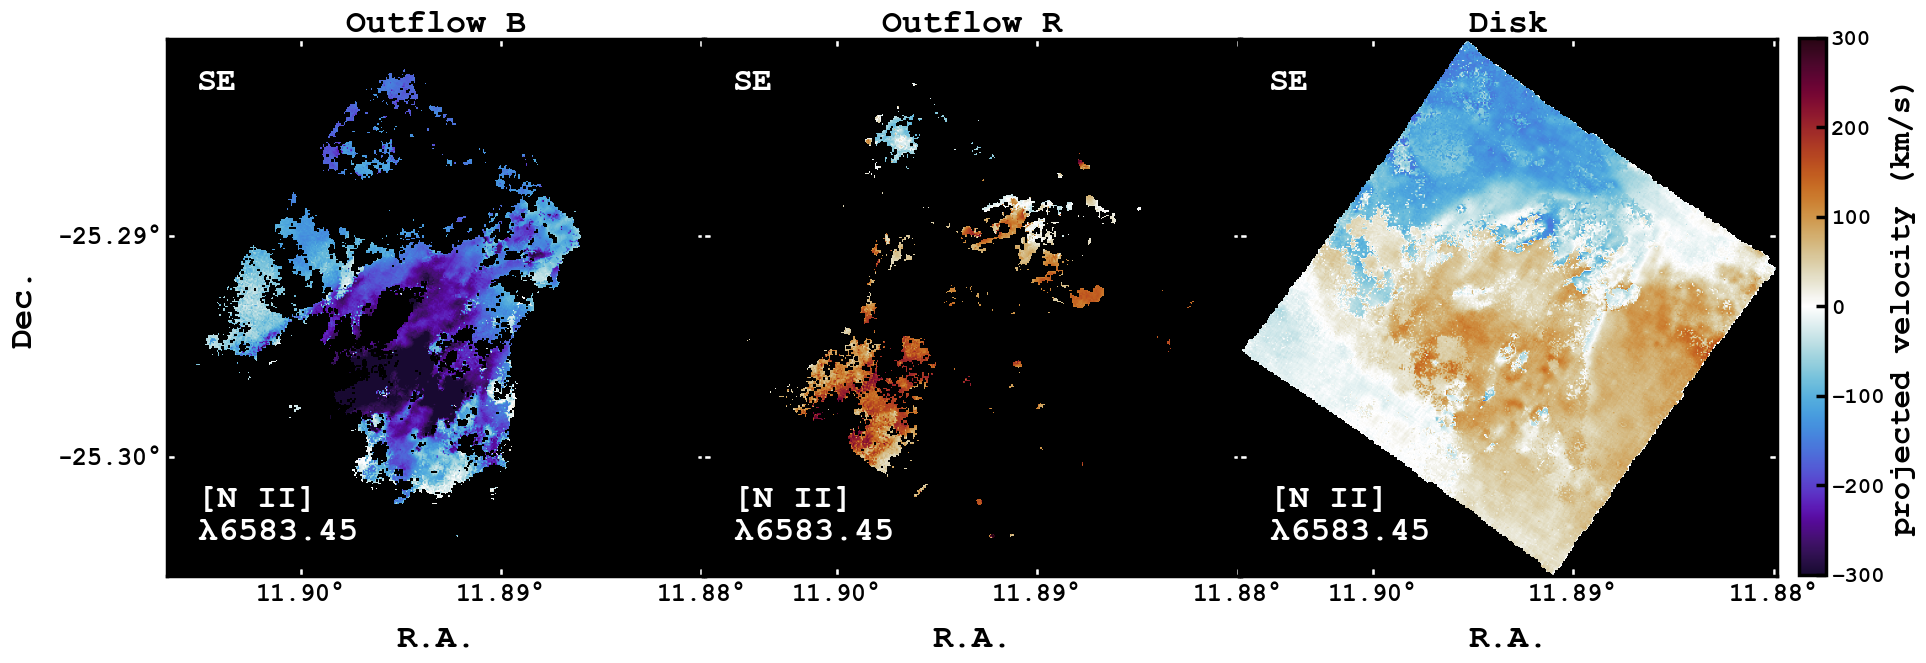

In [12]:
# cmap = 'turbo'
cmap = cmr.fusion_r
# cmap = cmr.redshift
# cmap = cmr.infinity
# cmap = cmr.tropical_r
# cmap = 'rainbow'
fig = plt.figure(figsize=(20,6))

# BLUESHIFTED OUTFLOW
ax1 = plt.subplot(1, 3, 1, projection=w)
im = ax1.imshow(outflow1_vel, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap)
ax1.set_title('Outflow B', fontsize=24)
ax1.coords[0].set_major_formatter('d.dd')
ax1.coords[1].set_major_formatter('d.dd')
ax1.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
ax1.set_xlabel('R.A.', fontsize=24)
ax1.set_ylabel('Dec.', fontsize=24)
ax1.set_facecolor('black')

at = AnchoredText('[N II]\n$\lambda6583.45$', prop=Afont, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)
at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)

ax2 = plt.subplot(1, 3, 2, projection=w)
im = ax2.imshow(outflow2_vel, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap) #vmin=vmin, vmax=vmax, cmap='rainbow')
ax2.set_title('Outflow R', fontsize=24)
ax2.coords[0].set_major_formatter('d.dd')
ax2.coords[1].set_major_formatter('d.dd')
ax2.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
ax2.set_xlabel('R.A.', fontsize=24)
ax2.coords[1].set_auto_axislabel(False)
ax2.coords[1].set_ticklabel_visible(False)
ax2.set_facecolor('black')

at = AnchoredText('[N II]\n$\lambda6583.45$', prop=Afont, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at)
at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at)

ax3 = plt.subplot(1, 3, 3, projection=w)
im = ax3.imshow(disk_vel, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap)#vmin=vmin, vmax=vmax, origin='lower', cmap='rainbow')
ax3.coords[0].set_major_formatter('d.dd')
ax3.coords[1].set_major_formatter('d.dd')
ax3.set_title('Disk', fontsize=24)
ax3.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
ax3.coords[0].set_auto_axislabel(False)
ax3.coords[1].set_auto_axislabel(False)
ax3.coords[1].set_ticklabel_visible(False)
ax3.set_xlabel('R.A.', fontsize=24)
ax3.set_facecolor('black')

at = AnchoredText('[N II]\n$\lambda 6583.45$', prop=Afont, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at)
at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at)

cax = ax3.inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
                                             # [x0, y0, width, height] where x0, y0 = lower left corner
bar = fig.colorbar(im, ax=ax3, cax=cax)
bar.set_label('projected velocity (km/s)', fontsize=22)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

plt.tight_layout()
plt.subplots_adjust(wspace=-0.3, hspace=0)
# plt.savefig('../ngc253/visuals/se_vels.png',bbox_inches='tight', dpi=200)

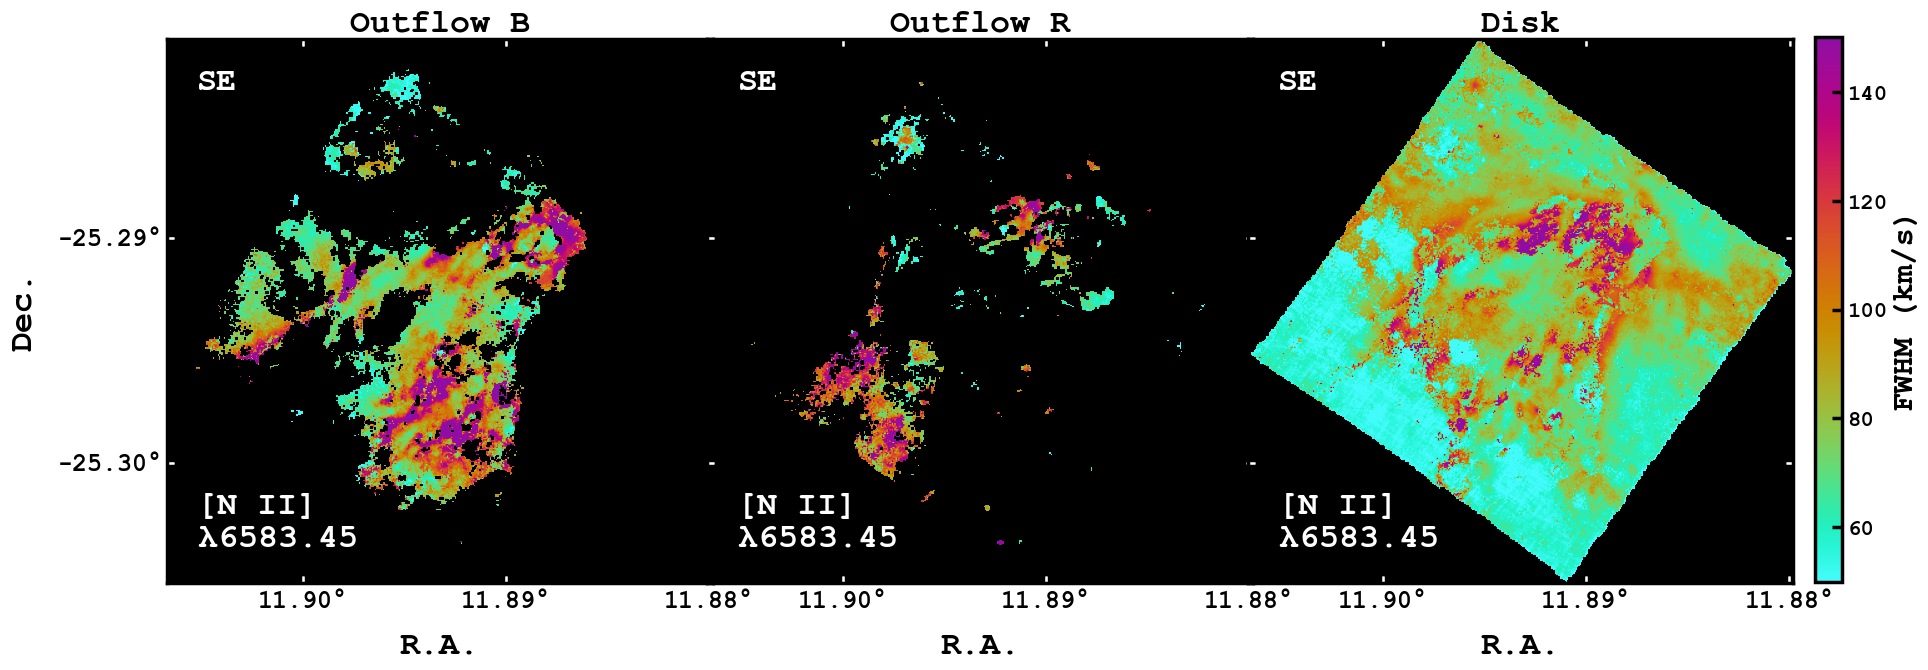

In [13]:
cmap = cmr.tropical_r
fig = plt.figure(figsize=(20,6))

vmin=50
vmax=150

# BLUESHIFTED OUTFLOW
ax1 = plt.subplot(1, 3, 1, projection=w)
im = ax1.imshow(outflow1_fwhm, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap)
ax1.set_title('Outflow B', fontsize=24)
ax1.coords[0].set_major_formatter('d.dd')
ax1.coords[1].set_major_formatter('d.dd')
ax1.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
ax1.set_xlabel('R.A.', fontsize=24)
ax1.set_ylabel('Dec.', fontsize=24)
ax1.set_facecolor('black')

at = AnchoredText('[N II]\n$\lambda6583.45$', prop=Afont, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)
at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)

ax2 = plt.subplot(1, 3, 2, projection=w)
im = ax2.imshow(outflow2_fwhm, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap) #vmin=vmin, vmax=vmax, cmap='rainbow')
ax2.set_title('Outflow R', fontsize=24)
ax2.coords[0].set_major_formatter('d.dd')
ax2.coords[1].set_major_formatter('d.dd')
ax2.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
ax2.set_xlabel('R.A.', fontsize=24)
ax2.coords[1].set_auto_axislabel(False)
ax2.coords[1].set_ticklabel_visible(False)
ax2.set_facecolor('black')

at = AnchoredText('[N II]\n$\lambda6583.45$', prop=Afont, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at)
at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at)

ax3 = plt.subplot(1, 3, 3, projection=w)
im = ax3.imshow(disk_fwhm, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap)#vmin=vmin, vmax=vmax, origin='lower', cmap='rainbow')
ax3.coords[0].set_major_formatter('d.dd')
ax3.coords[1].set_major_formatter('d.dd')
ax3.set_title('Disk', fontsize=24)
ax3.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
ax3.coords[0].set_auto_axislabel(False)
ax3.coords[1].set_auto_axislabel(False)
ax3.coords[1].set_ticklabel_visible(False)
ax3.set_xlabel('R.A.', fontsize=24)
ax3.set_facecolor('black')

at = AnchoredText('[N II]\n$\lambda 6583.45$', prop=Afont, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at)
at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at)

cax = ax3.inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
                                             # [x0, y0, width, height] where x0, y0 = lower left corner
bar = fig.colorbar(im, ax=ax3, cax=cax)
bar.set_label('FWHM (km/s)', fontsize=22)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

plt.tight_layout()
plt.subplots_adjust(wspace=-0.3, hspace=0)
# plt.savefig('../ngc253/visuals/se_fwhm.png',bbox_inches='tight', dpi=200)

Write everything to file to then be used for analysis in other notebooks.

In [26]:
hdu.header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  437 / length of data axis 1                          
NAXIS2  =                  436 / length of data axis 2                          
NAXIS3  =                 3801 / length of data axis 3                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
EXTNAME = 'DATA    '           / This extension contains data values            
DATASUM = '2086791948'         / data unit checksum updated 2018-11-22T21:20:49 
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'  

In [40]:
# make the header
cube = SpectralCube.read('../../ngc253/data/ADP.2018-11-22T21_29_46.157.fits', hdu=1)  
hdr = cube.header
hdr['CUNIT3'] = 'km s-1'
hdr['CTYPE3'] = ('VOPT-W2W', 'Optical velocity (linear)')
hdr

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3                                                  
NAXIS1  =                  437                                                  
NAXIS2  =                  436                                                  
NAXIS3  =                 3801                                                  
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
EXTNAME = 'DATA    '           / This extension contains data values            
DATASUM = '2086791948'         / data unit checksum updated 2018-11-22T21:20:49 
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'  

In [41]:
ERRoutflow1_vel = np.full((y,x), np.nan)
ERRdisk_vel = np.full((y,x), np.nan)
ERRoutflow2_vel = np.full((y,x), np.nan)

ERRdisk_vel[which_model == 1.] = ERRvel_map1[which_model == 1.]  # assume 1 is disk
ERRdisk_vel[(which_model == 2.) & mask2_b] = ERRvel_map2_b[(which_model == 2.) & mask2_b]
ERRdisk_vel[(which_model == 2.) & mask2_r] = ERRvel_map2_r[(which_model == 2.) & mask2_r]
ERRdisk_vel[(which_model == 3.) & mask3_b] = ERRvel_map3_b[(which_model == 3.) & mask3_b]
ERRdisk_vel[(which_model == 3.) & mask3_0] = ERRvel_map3_0[(which_model == 3.) & mask3_0]
ERRdisk_vel[(which_model == 3.) & mask3_r] = ERRvel_map3_r[(which_model == 3.) & mask3_r]

ERRoutflow1_vel[(which_model == 2.) & mask2_r] = ERRvel_map2_b[(which_model == 2.) & mask2_r]
ERRoutflow1_vel[(which_model == 3.) & mask3_r] = ERRvel_map3_b[(which_model == 3.) & mask3_r]
ERRoutflow1_vel[(which_model == 3.) & mask3_0] = ERRvel_map3_b[(which_model == 3.) & mask3_0]

ERRoutflow2_vel[(which_model == 2.) & mask2_b] = ERRvel_map2_r[(which_model == 2.) & mask2_b]
ERRoutflow2_vel[(which_model == 3.) & mask3_b] = ERRvel_map3_r[(which_model == 3.) & mask3_b]
ERRoutflow2_vel[(which_model == 3.) & mask3_0] = ERRvel_map3_r[(which_model == 3.) & mask3_0]

hdul = fits.PrimaryHDU(data=ERRdisk_vel, header=hdr)
hdul.writeto('../../ngc253/data/output_maps/ngc253_muse_se_niib_vel_disk_ERR.fits',  overwrite=True)

hdul = fits.PrimaryHDU(data=ERRoutflow1_vel, header=hdr)
hdul.writeto('../../ngc253/data/output_maps/ngc253_muse_se_niib_vel_outflow_blue_ERR.fits',  overwrite=True)

hdul = fits.PrimaryHDU(data=ERRoutflow2_vel, header=hdr)
hdul.writeto('../../ngc253/data/output_maps/ngc253_muse_se_niib_vel_outflow_red_ERR.fits',  overwrite=True)


In [42]:
ERRoutflow1_amp = np.full((y,x), np.nan)
ERRdisk_amp = np.full((y,x), np.nan)
ERRoutflow2_amp = np.full((y,x), np.nan)

ERRdisk_amp[which_model == 1.] = ERRamp_map1[which_model == 1.]  # assume 1 is disk
ERRdisk_amp[(which_model == 2.) & mask2_b] = ERRamp_map2_b[(which_model == 2.) & mask2_b]
ERRdisk_amp[(which_model == 2.) & mask2_r] = ERRamp_map2_r[(which_model == 2.) & mask2_r]
ERRdisk_amp[(which_model == 3.) & mask3_b] = ERRamp_map3_b[(which_model == 3.) & mask3_b]
ERRdisk_amp[(which_model == 3.) & mask3_0] = ERRamp_map3_0[(which_model == 3.) & mask3_0]
ERRdisk_amp[(which_model == 3.) & mask3_r] = ERRamp_map3_r[(which_model == 3.) & mask3_r]

ERRoutflow1_amp[(which_model == 2.) & mask2_r] = ERRamp_map2_b[(which_model == 2.) & mask2_r]
ERRoutflow1_amp[(which_model == 3.) & mask3_r] = ERRamp_map3_b[(which_model == 3.) & mask3_r]
ERRoutflow1_amp[(which_model == 3.) & mask3_0] = ERRamp_map3_b[(which_model == 3.) & mask3_0]

ERRoutflow2_amp[(which_model == 2.) & mask2_b] = ERRamp_map2_r[(which_model == 2.) & mask2_b]
ERRoutflow2_amp[(which_model == 3.) & mask3_b] = ERRamp_map3_r[(which_model == 3.) & mask3_b]
ERRoutflow2_amp[(which_model == 3.) & mask3_0] = ERRamp_map3_r[(which_model == 3.) & mask3_0]

hdul = fits.PrimaryHDU(data=ERRdisk_amp, header=hdr)
hdul.writeto('../../ngc253/data/output_maps/ngc253_muse_se_niib_amp_disk_ERR.fits',  overwrite=True)

hdul = fits.PrimaryHDU(data=ERRoutflow1_amp, header=hdr)
hdul.writeto('../../ngc253/data/output_maps/ngc253_muse_se_niib_amp_outflow_blue_ERR.fits',  overwrite=True)

hdul = fits.PrimaryHDU(data=ERRoutflow2_amp, header=hdr)
hdul.writeto('../../ngc253/data/output_maps/ngc253_muse_se_niib_amp_outflow_red_ERR.fits',  overwrite=True)

In [43]:
hdul = fits.PrimaryHDU(data=disk_vel, header=hdr)
hdul.writeto('../../ngc253/data/output_maps/ngc253_muse_se_niib_vel_disk.fits',  overwrite=True)

hdul = fits.PrimaryHDU(data=outflow1_vel, header=hdr)
hdul.writeto('../../ngc253/data/output_maps/ngc253_muse_se_niib_vel_outflow_blue.fits',  overwrite=True)

hdul = fits.PrimaryHDU(data=outflow2_vel, header=hdr)
hdul.writeto('../../ngc253/data/output_maps/ngc253_muse_se_niib_vel_outflow_red.fits',  overwrite=True)



hdul = fits.PrimaryHDU(data=disk_amp, header=hdr)
hdul.writeto('../../ngc253/data/output_maps/ngc253_muse_se_niib_amp_disk.fits',  overwrite=True)

hdul = fits.PrimaryHDU(data=outflow1_amp, header=hdr)
hdul.writeto('../../ngc253/data/output_maps/ngc253_muse_se_niib_amp_outflow_blue.fits',  overwrite=True)

hdul = fits.PrimaryHDU(data=outflow2_amp, header=hdr)
hdul.writeto('../../ngc253/data/output_maps/ngc253_muse_se_niib_amp_outflow_red.fits',  overwrite=True)


hdul = fits.PrimaryHDU(data=disk_fwhm, header=hdr)
hdul.writeto('../../ngc253/data/output_maps/ngc253_muse_se_niib_fwhm_disk.fits',  overwrite=True)

hdul = fits.PrimaryHDU(data=outflow1_fwhm, header=hdr)
hdul.writeto('../../ngc253/data/output_maps/ngc253_muse_se_niib_fwhm_outflow_blue.fits',  overwrite=True)

hdul = fits.PrimaryHDU(data=outflow2_fwhm, header=hdr)
hdul.writeto('../../ngc253/data/output_maps/ngc253_muse_se_niib_fwhm_outflow_red.fits',  overwrite=True)
